In [1]:
using Pkg
Pkg.activate("/media/mat/HDD/AdaptiveTransportMap/")

 Activating environment at `/media/mat/HDD/AdaptiveTransportMap/Project.toml`


In [2]:
using Revise
using AdaptiveTransportMap
using LinearAlgebra
import LinearAlgebra: ldiv!, dot
using Test
using ForwardDiff
using SpecialFunctions
using BenchmarkTools
using TransportMap
using QuadGK
using Polynomials
using Distributions
using Random
using LoopVectorization
using Optim
using NLsolve
using MLDataUtils
using MLDataPattern
using Test
using SparseArrays
using AdaptiveTransportMap: vander, transform!, evaluate, ncoeff, optimize, negative_log_likelihood!, derivative

# using Profile
# using ProfileView
using StaticArrays
using QRupdate
using Plots

In [114]:
Nx = 3
Ne = 8
m = 20

idx = [0 0 0; 0 0 1; 0 1 0; 0 1 1; 0 1 2; 1 0 0]


Nψ = 6
coeff = [ 0.20649582065364197;
         -0.5150990160472986;
          2.630096893080717;
          1.13653076177397;
          0.6725837371023421;
         -1.3126095306624133]
# coeff = zeros(Nψ)
# idx = rand(0:2,Nψ, Nx)
# coeff = randn(Nψ)

# coeff = [-0.28829821609289064;
#          -1.1768877197305714;
#           0.40090743090076547];
coeff0 = deepcopy(coeff)
#           1.101330816362896];
C = MapComponent(m, Nx, idx, coeff; α = 1e-6);
C0 = deepcopy(C);

In [115]:
X =  Matrix([ 1.12488     0.0236348   -0.958426;
             -0.0493163   0.00323509  -0.276744;
              1.11409     0.976117     0.256577;
             -0.563545    0.179956    -0.418444;
              0.0780599   0.371091    -0.742342;
              1.77185    -0.175635     0.32151;
             -0.869045   -0.0570977   -1.06254;
             -0.165249   -2.70636      0.548725]')

# X = randn(Nx, Ne) .* randn(Nx, Ne) + cos.(randn(Nx, Ne))
L = LinearTransform(X)
transform!(L, X);

In [116]:
S = Storage(C.I.f, X)
S̃ = Storage(C.I.f, X);

In [117]:
F = QRscaling(S);

In [118]:
@time res = Optim.optimize(Optim.only_fg!(negative_log_likelihood(S, C, X)), coeff, Optim.LBFGS(; m = 20),
                           Optim.Options(store_trace=true))

  0.000893 seconds (9.93 k allocations: 1.280 MiB)


 * Status: success

 * Candidate solution
    Final objective value:     7.190990e-01

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 8.10e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 8.70e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 7.77e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.08e-15 ≰ 0.0e+00
    |g(x)|                 = 2.39e-10 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    15
    f(x) calls:    47
    ∇f(x) calls:   47


In [119]:
precond = zeros(ncoeff(C), ncoeff(C))
precond!(precond, coeff, S, C, X)
@time resprecond = Optim.optimize(Optim.only_fg!(negative_log_likelihood(S, C, X)), coeff,
                           Optim.LBFGS(; m = 20, P = Preconditioner(precond)),
                           Optim.Options(store_trace=true))

  0.000515 seconds (5.32 k allocations: 704.828 KiB)


 * Status: success

 * Candidate solution
    Final objective value:     7.190990e-01

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 9.90e-06 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.06e-07 ≰ 0.0e+00
    |f(x) - f(x')|         = 8.52e-14 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.18e-13 ≰ 0.0e+00
    |g(x)|                 = 6.59e-10 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    10
    f(x) calls:    25
    ∇f(x) calls:   25


In [120]:
S̃ = Storage(C.I.f, X)
J̃ = 0.0
dJ̃ = zeros(Nψ)
c̃oeff0 = F.U*coeff0

mul!(S̃.ψoffψd0, S̃.ψoffψd0, F.Uinv)
mul!(S̃.ψoffdψxd, S̃.ψoffdψxd, F.Uinv)

qrprecond = zeros(ncoeff(C), ncoeff(C))
qrprecond!(qrprecond, c̃oeff0, F, S̃, C, X)

@time r̃es = Optim.optimize(Optim.only_fg!(qrnegative_log_likelihood(F, S̃, C, X)), c̃oeff0, Optim.LBFGS(; m = 20),
                           Optim.Options(store_trace=true))

  0.000780 seconds (8.17 k allocations: 941.703 KiB)


 * Status: success

 * Candidate solution
    Final objective value:     7.190990e-01

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 5.64e-06 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.60e-06 ≰ 0.0e+00
    |f(x) - f(x')|         = 4.33e-12 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 6.02e-12 ≰ 0.0e+00
    |g(x)|                 = 2.69e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    10
    f(x) calls:    30
    ∇f(x) calls:   30


In [121]:
# With QR and Hessian approximation
S̃ = Storage(C.I.f, X)
J̃ = 0.0
dJ̃ = zeros(Nψ)
c̃oeff0 = F.U*coeff0

S̃.ψoffψd0 .=  S̃.ψoffψd0 * F.Uinv
S̃.ψoffdψxd .= S̃.ψoffdψxd * F.Uinv

qrprecond = zeros(ncoeff(C), ncoeff(C))
qrprecond!(qrprecond, c̃oeff0, F, S̃, C, X)

@time r̃esprecond = Optim.optimize(Optim.only_fg!(qrnegative_log_likelihood(F, S̃, C, X)), c̃oeff0, 
                           Optim.LBFGS(; m = 20, P = Preconditioner(qrprecond)),
                           Optim.Options(store_trace=true))

  0.000679 seconds (6.82 k allocations: 788.875 KiB)


 * Status: success

 * Candidate solution
    Final objective value:     7.190990e-01

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 8.98e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 7.32e-07 ≰ 0.0e+00
    |f(x) - f(x')|         = 8.67e-14 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.21e-13 ≰ 0.0e+00
    |g(x)|                 = 1.45e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    10
    f(x) calls:    25
    ∇f(x) calls:   25


In [122]:
function timing()
    @btime res = Optim.optimize(Optim.only_fg!(negative_log_likelihood(S, C, X)), coeff, Optim.LBFGS(; m = 20),
                           Optim.Options(store_trace=false));
    
    @btime resprecond = Optim.optimize(Optim.only_fg!(negative_log_likelihood(S, C, X)), coeff,
                           Optim.LBFGS(; m = 20, P = Preconditioner(precond)));
    
    @btime r̃es = Optim.optimize(Optim.only_fg!(qrnegative_log_likelihood(F, S̃, C, X)), c̃oeff0, Optim.LBFGS(; m = 20),
                           Optim.Options(store_trace=false));
    
    @btime r̃esprecond = Optim.optimize(Optim.only_fg!(qrnegative_log_likelihood(F, S̃, C, X)), c̃oeff0, 
                           Optim.LBFGS(; m = 20, P = Preconditioner(qrprecond)),
                           Optim.Options(store_trace=false));
end

timing (generic function with 1 method)

In [123]:
timing()

  737.654 μs (9848 allocations: 1.27 MiB)
  409.447 μs (5280 allocations: 699.23 KiB)
  654.148 μs (8118 allocations: 934.67 KiB)
  550.935 μs (6767 allocations: 781.84 KiB)


 * Status: success

 * Candidate solution
    Final objective value:     7.190990e-01

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 8.98e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 7.32e-07 ≰ 0.0e+00
    |f(x) - f(x')|         = 8.67e-14 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.21e-13 ≰ 0.0e+00
    |g(x)|                 = 1.45e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    10
    f(x) calls:    25
    ∇f(x) calls:   25


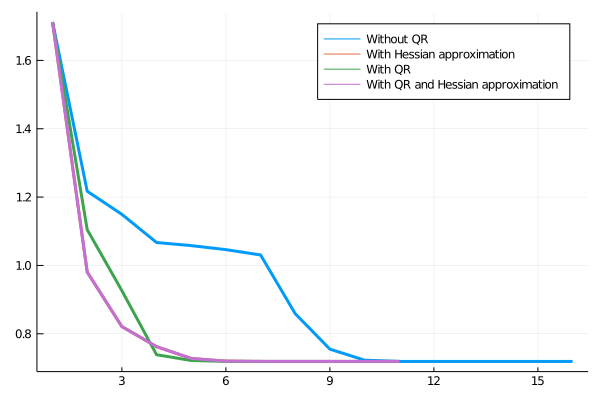

In [131]:
sca(Optim.f_trace(res), linewidth = 3, label = "Without QR")
plot!(Optim.f_trace(resprecond), linewidth = 3, label = "With Hessian approximation")
plot!(Optim.f_trace(r̃es), linewidth = 3, label = "With QR")
plot!(Optim.f_trace(r̃esprecond), linewidth = 3, label = "With QR and Hessian approximation")

In [125]:
res.minimizer

6-element Array{Float64,1}:
  19.140940292925507
 -57.71114658268417
 -34.295117390166155
  93.09349957328978
   2.214935279736011
   5.36054213807699

In [126]:
r̃es.minimizer

6-element Array{Float64,1}:
 -0.4018645157603582
 -0.9881171838225097
 -0.15913270404366356
 -1.226889826902165
  0.4167748529075588
 -0.6015178325629994

In [127]:
F.Uinv*r̃es.minimizer

6-element Array{Float64,1}:
  19.14094035253657
 -57.711146681926536
 -34.295117548168946
  93.09349985100788
   2.214935235183977
   5.360542125964209

In [128]:
F.Uinv*r̃esprecond.minimizer

6-element Array{Float64,1}:
  19.14094017972538
 -57.711146348335205
 -34.29511721846594
  93.09349918969032
   2.214935299606997
   5.36054215598486